# Signal-Relay Chemotaxis in Microglia  
### Numerical Results and Analysis

This notebook presents the numerical results of a hybrid
Eulerian–Lagrangian model for microglial chemotaxis with signal relay.

We focus on:
- Emergence of collective behavior
- Comparison between discrete agent-based relay and smooth source models
- Quantitative measures of recruitment and signal propagation


In [43]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from parameters import *
from agents import Agents
from pde import update_signal
from coupling import deposit_sources

plt.rcParams["figure.dpi"] = 120


## Model Parameters

All parameters are defined in `parameters.py`.
The domain represents a confined brain tissue region with no-flux boundaries.

Key parameters:
- Diffusion coefficient $D$
- Degradation rate $\gamma$
- Chemotactic sensitivity $\chi$
- Activation threshold $T_{\text{threshold}}$


In [44]:
def compute_radial_profile(c):
    y, x = np.indices(c.shape)
    center = np.array(c.shape) // 2
    r = np.sqrt((x-center[1])**2 + (y-center[0])**2).astype(int)

    tbin = np.bincount(r.ravel(), c.ravel())
    nr = np.bincount(r.ravel())
    return tbin / np.maximum(nr, 1)


def plot_signal(c, title="Signal field"):
    plt.figure(figsize=(5,4))
    plt.imshow(c.T, origin="lower", cmap="inferno")
    plt.colorbar(label="Signal concentration")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()


## Hybrid Simulation: Agent-Based Signal Relay

We first simulate the full hybrid model, where activated microglia act
as discrete, moving sources of the signaling molecule.


Initial max signal: 2.6406660163773523


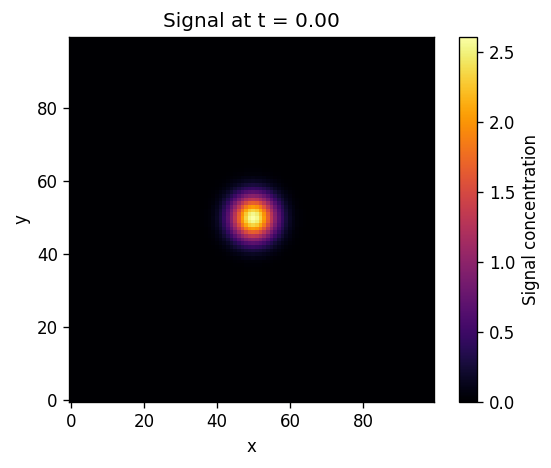

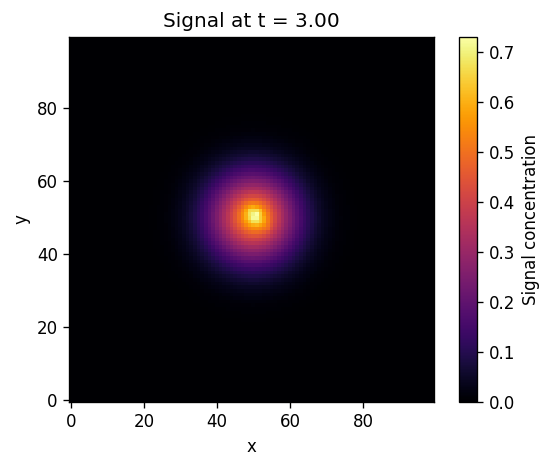

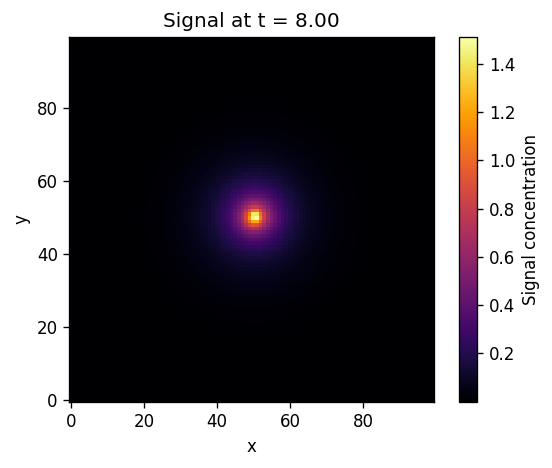

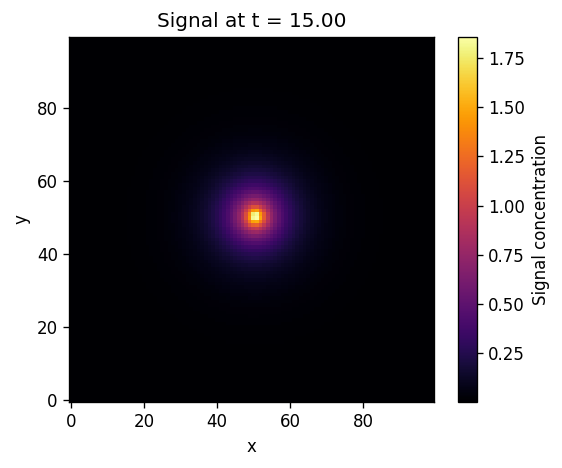

In [45]:
# Initialize
c = np.zeros((Nx, Ny))
agents = Agents(n_agents, Lx, Ly)

# Small, strong initial injury (only ~20–40 agents will see >0.6 at t=0)
center_x = Nx // 2
center_y = Ny // 2
sigma_patches = 4.0
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
dist = np.sqrt((xx - center_x)**2 + (yy - center_y)**2)
c = 3.0 * np.exp(-dist**2 / (2 * sigma_patches**2))

# Tiny pre-diffusion (just smooths the blob a bit)
for _ in range(10):
    c = update_signal(c, np.zeros((Nx, Ny)), D, gamma, dt, dx, dy)

print("Initial max signal:", c.max())   # should be ~3.0

activated_counts = []
mean_distances = []

center_phys = np.array([Lx/2, Ly/2])

for step in range(steps):
    agents.update_state(c, threshold, dx)

    source = deposit_sources(agents, c.shape, dx, sigma)
    c = update_signal(c, source, D, gamma, dt, dx, dy)

    # gradient & move (your existing code)
    grad_x, grad_y = np.gradient(c, dx)
    ix = (agents.pos[:,0] / dx).astype(int) % Nx
    iy = (agents.pos[:,1] / dx).astype(int) % Ny
    grad = np.stack([grad_x[ix, iy], grad_y[ix, iy]], axis=1)
    agents.move(grad, chi, D_eff, dt, epsilon, Lx, Ly)

    # metrics
    activated_counts.append(np.sum(agents.active))
    distances = np.linalg.norm(agents.pos - center_phys, axis=1)
    mean_distances.append(distances.mean())

    # snapshots
    if step in [0, 300, 800, 1500, 2800]:
        plot_signal(c, title=f"Signal at t = {step*dt:.2f}")

## Microglial Distribution

We overlay agent positions on the signal field to visualize
chemotactic clustering around the injury site.


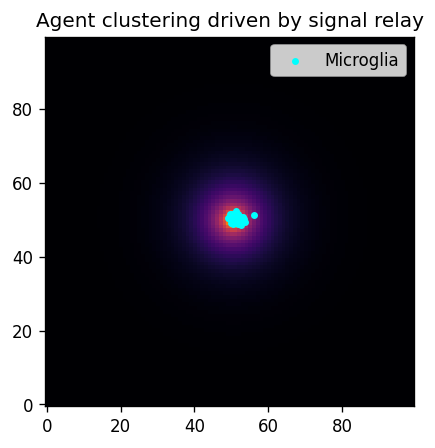

In [46]:
plt.figure(figsize=(5,4))
plt.imshow(c.T, origin="lower", cmap="inferno")
plt.scatter(
    agents.pos[:,0] / dx,
    agents.pos[:,1] / dx,
    c="cyan", s=10, label="Microglia"
)
plt.legend()
plt.title("Agent clustering driven by signal relay")
plt.show()


## Recruitment Dynamics

Signal relay leads to a rapid increase in the number of activated agents,
indicating collective recruitment.


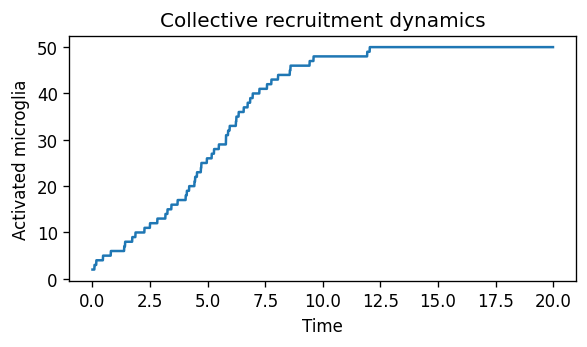

In [47]:
time = np.arange(steps) * dt

plt.figure(figsize=(5,3))
plt.plot(time, activated_counts)
plt.xlabel("Time")
plt.ylabel("Activated microglia")
plt.title("Collective recruitment dynamics")
plt.tight_layout()
plt.show()


## Directed Migration Toward Injury

The mean distance of agents from the injury site decreases over time,
demonstrating coordinated chemotactic movement.


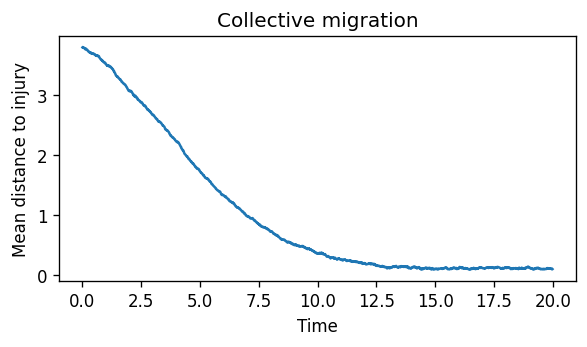

In [40]:
plt.figure(figsize=(5,3))
plt.plot(time, mean_distances)
plt.xlabel("Time")
plt.ylabel("Mean distance to injury")
plt.title("Collective migration")
plt.tight_layout()
plt.show()


## Continuum-Only Reference Model

To assess the role of discrete agents, we compare the hybrid model
with a continuum-only simulation using a fixed, smooth source.


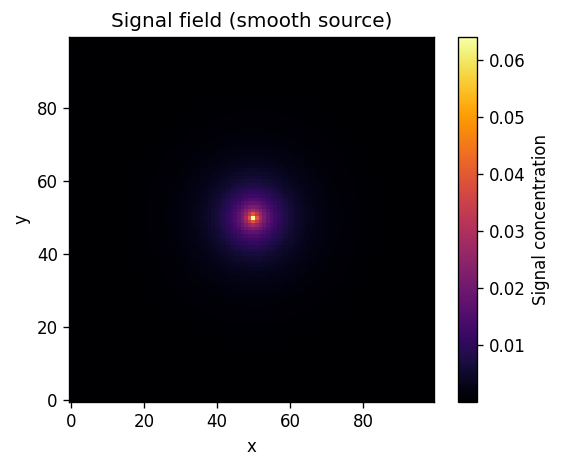

In [41]:
c_smooth = np.zeros((Nx, Ny))
c_smooth[Nx//2, Ny//2] = 5.0

for step in range(steps):
    source = np.zeros_like(c_smooth)
    source[Nx//2, Ny//2] = sigma
    c_smooth = update_signal(c_smooth, source, D, gamma, dt, dx, dy)

plot_signal(c_smooth, title="Signal field (smooth source)")


## Radial Signal Profiles

We compare the spatial extent of signaling between the hybrid
agent-based model and the continuum-only model.


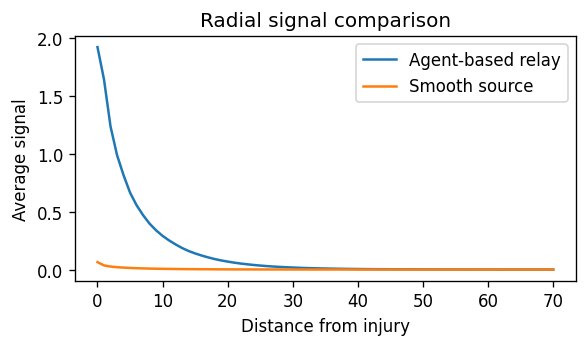

In [42]:
profile_agents = compute_radial_profile(c)
profile_smooth = compute_radial_profile(c_smooth)

plt.figure(figsize=(5,3))
plt.plot(profile_agents, label="Agent-based relay")
plt.plot(profile_smooth, label="Smooth source")
plt.xlabel("Distance from injury")
plt.ylabel("Average signal")
plt.legend()
plt.title("Radial signal comparison")
plt.tight_layout()
plt.show()


## Summary of Results

- Signal relay produces broader and more persistent signaling fields
- Discrete agents generate non-trivial spatial structures
- Recruitment dynamics exhibit nonlinear threshold behavior
- Hybrid modeling captures phenomena not visible in continuum-only models
